# Biweekly-Checkin 3
# Jacob Tiede
## Exploitation of Prior Techniques
I have spent the last 4 weeks developing a roster of techniques in order to work with most data types. To start this week off I want to take a second to use some of these techniques on data that interests me. To start I would like to explain a data-type that I have been studying for work outside of class.
### GWAS Data:
Genome Wide Association Studies have been performed for many years now, with their genesis really coming around the mid 2000s when it became cheap and easy to sequence large genomes. These studies used short sequences of highly recombinant DNA regions (regions of the genome that mutate frequently in a population) to try and extrapolate information about how different sections of the genome are related to each other as well as the phenotype (the outward expression of genes) of an individual. Traditionally, people analyze these genomic sequences using statistics which require several strong assumptions to work (for instance that each mutation that contributes to a disease makes its contribution linearly), but what happens when a disease violates these assumptions? This is a question that I would like to work on for my thesis, and my solution is to apply deep learning algorithms to this data. Deep learning requires no assumptions about the behavior of the data, so this has the potential to find links between genes, specific mutations, and pathologies that would not otherwise be possible. I would like to use section as a means of testing the viability of various deep learning approaches on this type of data. To do this I will perform a numerical experiment, but before we get to that I will briefly describe the structure of this data:
#### Aside: The Structure of this Data
To understand the values this data can take on one must first recall that humans are diploid organisms, meaning we have two copies of every chromosome in our genome. This means that for every possible viable mutation there are 3 possible values for a genotype. Let's say that at position 1 in the genome there is a viable mutation that our model keeps track of and the specific nucleotide change is A->T. If both of the alleles of an individual are A we will record that as a 0 in our data, if both are T this will be a 2 and if one is an A and the other is a T then a 1 is recorded. Note that this has nothing to do with the relationship of this mutation to the phenotype (as some genetics class will teach with discussion of dominant vs recessive genes), and is instead just an encoding of the genotype. This means that the rows of our data will represent an individual's genotype, while the columns represent what specific mutations we keep track of. It should also be noted that there is no particular order of the columns of this data set like there is with text or image data. If we permute the columns of GWAS data we should still get the same predictions, which presents a problem for some deep learning models. With this definition in mind I will now describe the numerical experiment that I would like to conduct.
#### Numerical Experiment
I would like to imagine a very simple pathology that is completely determined by two mutations in a single gene, these will be the first two columns in our dataset. If both of these mutations are a 2 then we will say that the person has the disorder, if only 1 is a 2 then there is a 50% chance of having the pathology, and if neither are 2s then we will definitely not have the pathology. Another note about this type of data is that 0 always represents the most common genotype in the population, so this data should have more 0s than non-zeros, we'll say that there's a 70% chance that a person has a 0, a 15% chance that a person has a 1, and a 15% chance that a person has a 2 for a particular mutation (for non-pathological genotypes). We can use random number generators to make a "genome" with these specifications:


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
print("Is a GPU available? ")
torch.cuda.is_available()

Is a GPU available? 


True

In [2]:
def generateData(m,n):
    #start by generating a target, a 0 will represent that they do not have the pathology and a 1 will represent that they do have the pathology
    target = torch.randint(0,2, size = (m,1))
    
    #Now we will generate the mxn matrix of genotypes:
    data = torch.zeros(m,n)
    for i in range(m):
        #if this individual has the pathology
        if target[i,0] == 1:
            #flip a coin to determine if they have one or two pathological mutations
            r = torch.rand(1,1)
            if r <= 0.5:
                data[i,0] = 2
                data[i,1] = 2
            else:
                #flip a coin to determine which allel is a 2 
                r = torch.rand(1,1)
                if r <= .5:
                    data[i,0] = 2
                    data[i,1] = torch.randint(0,2, size = (1,1))
                else:
                    data[i,1] = 2
                    data[i,0] = torch.randint(0,2, size = (1,1))
            #determine the values of the rest of the mutations in this row
            for j in range(2, n):
                r = torch.rand(1,1)
                #~70% of the other mutations are 0
                if r <= .7:
                    data[i,j] = 0
                else:
                    data[i,j] = torch.randint(1,3, size = (1,1))
        #if they do not have the pathology
        else:
            r = torch.rand(1,1)
            #right now 50% of the data has the pathology and the other 50% does not. That means that 25% of the data are positive with only 1 pathological mutation
            #so we need to choose 25% of healthy individuals to have a pathological mutation to keep our statistics in line with the description
            if r <= .25:
                r = torch.rand(1,1)
                if r <= .5:
                    data[i,0] = 2
                    data[i,1] = torch.randint(0,2, size = (1,1))
                else:
                    data[i,1] = 2
                    data[i,0] = torch.randint(0,2, size = (1,1))
            else:
                data[i,1] = torch.randint(0,2, size = (1,1))
                data[i,0] = torch.randint(0,2, size = (1,1))
            for j in range(2, n):
                r = torch.rand(1,1)
                #~70% of the other mutations are 0
                if r <= .7:
                    data[i,j] = 0
                else:
                    data[i,j] = torch.randint(1,3, size = (1,1))
    return data,target
n=100
data, target = generateData(2**14,n)
testdata, testtarget = generateData(2**10,n)

Now, I'd like to try some models on this: the first being logistic regression since that would be statisticians tool of choice for this problem.

In [3]:
#logistic regression can be thought of as a neural net with all inputs mapped to one neuron, and a sigmoid non-linearity
class Net(nn.Module):
    def __init__(self, n):
        super(Net, self).__init__()
        self.n = n
        #Training doesn't do anything for this model, but I like to keep it around so I can adjust things quickly if need be
        self.training = True
        self.fc1 = nn.Linear(self.n,1)
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    def setTraining(self,x):
        self.training = x
model = Net(n)
model = model.cuda()

[10,   256] loss: 0.611
[20,   256] loss: 0.534
[30,   256] loss: 0.481
[40,   256] loss: 0.444
[50,   256] loss: 0.419
[60,   256] loss: 0.402
[70,   256] loss: 0.391
[80,   256] loss: 0.383
[90,   256] loss: 0.378
[100,   256] loss: 0.375
[110,   256] loss: 0.372
[120,   256] loss: 0.370
[130,   256] loss: 0.368
[140,   256] loss: 0.367
[150,   256] loss: 0.366
[160,   256] loss: 0.365
[170,   256] loss: 0.364
[180,   256] loss: 0.363
[190,   256] loss: 0.363
[200,   256] loss: 0.362


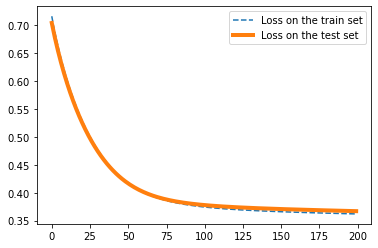

In [4]:
epochs = 200
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)
#we'll use a batch size of 64 which makes steps as the number of complete batches our generated data has
steps = int(np.floor(data.shape[0]/64))
#number of complete batches in the testing set
stepstest = int(np.floor(testdata.shape[0]/64))

#make some arrays to keep track of the losses for the train and test set
trainlosses_log = []
testlosses_log = []
epoch = []

for i in range(epochs):
    model.setTraining(True)
    running_loss = 0
    for j in range(steps):
        optimizer.zero_grad()
        batch = data[j*64:(j+1)*64,:]
        batch = batch.cuda()
        batch_target = target[j*64:(j+1)*64, :]
        batch_target = batch_target.cuda()
        outputs = model(batch.float())
        #our loss is calculated using cross entropy
        loss = criterion(outputs, batch_target.float())
        #calculate the gradients and take a step using the optimizer
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        #If we are at the end of an epoch we will find an record statistics including the test loss and train loss
        if j == steps-1:
            with torch.no_grad():
                running_testLoss = 0
                #tell the model that we are evaluating
                model.setTraining(False)
                model.eval()
                #Initialize pred on last epoch for confusion matrix
                if i == epochs-1: pred = torch.zeros((64*stepstest,1)).cuda()
                for k in range(stepstest):
                    batch = testdata[k*64:(k+1)*64,:]
                    batch = batch.cuda()
                    batch_target = testtarget[k*64:(k+1)*64, :]
                    batch_target = batch_target.cuda()
                    outputs = model(batch.float())
                    
                    #save predictions for a confusion matrix:
                    if i == epochs-1: pred[k*64:(k+1)*64] = outputs
                    loss = criterion(outputs, batch_target.float())
                    running_testLoss+=loss.item()
                
                    
                trainlosses_log.append(running_loss / steps)
                testlosses_log.append(running_testLoss/stepstest)
                epoch.append(i)
                #set model to train again
                model.train()
            if j == steps-1 and i%10 == 9:
                print('[%d, %5d] loss: %.3f' %
                      (i + 1, j + 1, running_loss / steps))
#plot testing and training loss
line1, = plt.plot(trainlosses_log, label="Loss on the train set", linestyle='--')
line2, = plt.plot(testlosses_log, label="Loss on the test set", linewidth=4)

# Create a legend for the first line.
first_legend = plt.legend(handles=[line1, line2], loc='upper right')

plt.show() 


In [5]:
pred = pred.cpu()
for i in range(pred.shape[0]):
    if pred[i,0] > .5:
        pred[i,0] = 1
    else:
        pred[i,0] = 0
print("The confusion matrix of logistic regression is:")
print(confusion_matrix(testtarget, pred))

The confusion matrix of logistic regression is:
[[406 109]
 [ 90 419]]


Quickly, let's find the Bayes limit of this data set, if we used an ideal prediction strategy. We are using binary cross entropy for our loss, and we have fixed the data so that ~50% of the data is ambiguous, so a perfect strategy would always correctly predict half the data, and have a 50-50 chance of getting the other half right. In binary cross entropy this would be a loss of $-\frac{1}{2}*log(1/2) \approx .34$, so we can see that logistic regression does not pick up on the perfect strategy. Now, to better understand confusion matrices we can use this article as a guide: https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62. We can see that our model makes similar errors in false positives and false negatives (false positives have a count of 87 and false negatives have a count of 95), but the article details that these metrics are not the best for determining which model is performing better than another. For that we will use an F-measure, which is defined as $\frac{2*recall*precision}{recall+precision}$. Finding this metric for logistic regression gives:


In [6]:
conMatrix = confusion_matrix(testtarget, pred)
precision = conMatrix[0,0]/(conMatrix[0,0]+conMatrix[0,1])
recall = conMatrix[0,0]/(conMatrix[0,0]+conMatrix[1,0])
print("The precision of logistic regression is: " + str(precision))
print("The recall of logistic regression is: " + str(recall))
print("The F-measure of logistic regression is: " + str(2*recall*precision/(recall+precision)))

The precision of logistic regression is: 0.7883495145631068
The recall of logistic regression is: 0.8185483870967742
The F-measure of logistic regression is: 0.8031651829871415


Since there measures are best for comparisons of models I will hold off on interpreting them for now. Next, I would like to try a conventional neural net with dropout regularization:

In [7]:
class Net(nn.Module):
    def __init__(self, n):
        super(Net, self).__init__()
        self.n = n
        self.training = True
        self.fc1 = nn.Linear(self.n,25)
        self.drop1 = nn.Dropout(.5)
        self.fc2 = nn.Linear(25,10)
        self.drop2 = nn.Dropout(.5)
        self.fc3 = nn.Linear(10,1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        if self.training:
            x = self.drop1(x)
        x = F.relu(self.fc2(x))
        if self.training:
            x=self.drop2(x)
        x = torch.sigmoid(self.fc3(x))
        return x
    def setTraining(self,x):
        self.training = x
model = Net(100)
model = model.cuda()

[10,   256] loss: 0.540
[20,   256] loss: 0.464
[30,   256] loss: 0.441
[40,   256] loss: 0.414
[50,   256] loss: 0.395
[60,   256] loss: 0.380
[70,   256] loss: 0.362
[80,   256] loss: 0.354
[90,   256] loss: 0.347
[100,   256] loss: 0.341
[110,   256] loss: 0.334
[120,   256] loss: 0.327
[130,   256] loss: 0.323
[140,   256] loss: 0.322
[150,   256] loss: 0.317
[160,   256] loss: 0.312
[170,   256] loss: 0.310
[180,   256] loss: 0.309
[190,   256] loss: 0.306
[200,   256] loss: 0.305


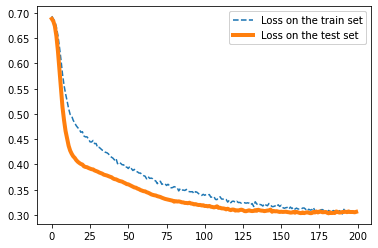

In [8]:
#Code here is without comments since it is the same as the prior training loop
epochs = 200
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)
steps = int(np.floor(data.shape[0]/64))
trainlosses_net = []
testlosses_net = []
epoch = []
stepstest = int(np.floor(testdata.shape[0]/64))
for i in range(epochs):
    model.setTraining(True)
    running_loss = 0
    for j in range(steps):
        optimizer.zero_grad()
        batch = data[j*64:(j+1)*64,:]
        batch = batch.cuda()
        batch_target = target[j*64:(j+1)*64, :]
        batch_target = batch_target.cuda()
        outputs = model(batch.float())
        loss = criterion(outputs, batch_target.float())
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        if j == steps-1:
            with torch.no_grad():
                running_testLoss = 0
                model.setTraining(False)
                model.eval()
                if i == epochs-1: pred = torch.zeros((64*stepstest,1)).cuda()
                for k in range(stepstest):
                    batch = testdata[k*64:(k+1)*64,:]
                    batch = batch.cuda()
                    batch_target = testtarget[k*64:(k+1)*64, :]
                    batch_target = batch_target.cuda()
                    outputs = model(batch.float())
                    if i == epochs-1: pred[k*64:(k+1)*64] = outputs
                    loss = criterion(outputs, batch_target.float())
                    running_testLoss+=loss.item()
                
                    
                trainlosses_net.append(running_loss / steps)
                testlosses_net.append(running_testLoss/stepstest)
                epoch.append(i)
                model.train()
            if j == steps-1 and i%10 == 9:
                print('[%d, %5d] loss: %.3f' %
                      (i + 1, j + 1, running_loss / steps))
line1, = plt.plot(trainlosses_net, label="Loss on the train set", linestyle='--')
line2, = plt.plot(testlosses_net, label="Loss on the test set", linewidth=4)

# Create a legend for the first line.
first_legend = plt.legend(handles=[line1,line2], loc='upper right')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)



plt.show() 

In [9]:
pred = pred.cpu()
for i in range(pred.shape[0]):
    if pred[i,0] > .5:
        pred[i,0] = 1
    else:
        pred[i,0] = 0
print("The confusion matrix of a simple neural net is:")
print(confusion_matrix(testtarget, pred))
conMatrix = confusion_matrix(testtarget, pred)
precision = conMatrix[0,0]/(conMatrix[0,0]+conMatrix[0,1])
recall = conMatrix[0,0]/(conMatrix[0,0]+conMatrix[1,0])
print("The precision of a simple neural net is: " + str(precision))
print("The recall of a simple neural net is: " + str(recall))
print("The F-measure of a simple neural net is: " + str(2*recall*precision/(recall+precision)))

The confusion matrix of a simple neural net is:
[[391 124]
 [ 23 486]]
The precision of a simple neural net is: 0.7592233009708738
The recall of a simple neural net is: 0.9444444444444444
The F-measure of a simple neural net is: 0.8417653390742733


We've actually converged to a loss that is lower than what is theoretically possible, but this might be due to the fact that we are using pseudo-random numbers to generate the data. However, even though results are encouraging, picking up on statistical aberrations is something that I would want to avoid on a real dataset. We can also note that we have a higher F-measure (which implies that our model is performing better in general), but this performance increase is almost entirely from recall (meaning our false negative rate has substantially dropped). In fact, we can see that this model is actually less precise than logistic regression (the false positive rate has increased), though since their composite measure is still higher I will conclude that a simple neural net does outperform logistic regression. Last week, I learned about TabNet, and I would like to see how it performs. I'll use the library implementation that I briefly looked at last week (found here: https://github.com/dreamquark-ai/tabnet, NOTE: what I have implemented here is not a typical use case for this library, and I had to go through the source code to find the class that I needed as well as how to do the feature attribution. This does not represent a well documented use case for this library):

In [23]:
from pytorch_tabnet.tab_network import TabNetNoEmbeddings

class Net(nn.Module):
    def __init__(self, n):
        super(Net, self).__init__()
        self.n = n
        self.tab = TabNetNoEmbeddings(n, 1)
    def forward(self, x):
        x = self.tab(x)
        return x
    def getMasks(self, x):
        return self.tab.forward_masks(x)

model = Net(100)
model = Net(n)
model = model.cuda()

[10,    64] loss: 0.245
[20,    64] loss: 0.245
[30,    64] loss: 0.244
[40,    64] loss: 0.242
[50,    64] loss: 0.239
[60,    64] loss: 0.247
[70,    64] loss: 0.234
[80,    64] loss: 0.233
[90,    64] loss: 0.233
[100,    64] loss: 0.232
[110,    64] loss: 0.233
[120,    64] loss: 0.230
[130,    64] loss: 0.232
[140,    64] loss: 0.259
[150,    64] loss: 0.229
[160,    64] loss: 0.232
[170,    64] loss: 0.224
[180,    64] loss: 0.215
[190,    64] loss: 0.217
[200,    64] loss: 0.207


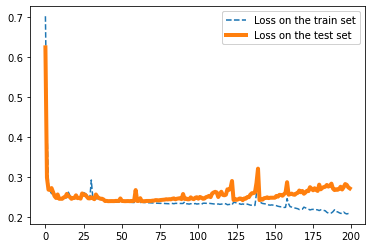

In [24]:
epochs = 200
batch_size = 128*2
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-2)
steps = int(np.floor(data.shape[0]/batch_size))
trainlosses_net = []
testlosses_net = []
epoch = []
stepstest = int(np.floor(testdata.shape[0]/batch_size))
for i in range(epochs):
    running_loss = 0
    for j in range(steps):
        optimizer.zero_grad()
        batch = data[j*batch_size:(j+1)*batch_size,:]
        batch = batch.cuda()
        batch_target = target[j*batch_size:(j+1)*batch_size, :]
        batch_target = batch_target.cuda()
        outputs = model(batch.float())
        #note that tabnet outputs two values, first the actual predictions of the model, and second the mask loss that we discussed last week
        #these must both be summed in the loss, with a small regularizing factor applied to the mask loss
        loss = criterion(torch.sigmoid(outputs[0]), batch_target.float()) - outputs[1]*.001
        #calculate the gradients and take a step using the optimizer
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        if j == steps-1:
            running_testLoss = 0
            if i == epochs-1: pred = torch.zeros((batch_size*stepstest,1)).cuda()
            for k in range(stepstest):
                batch = testdata[k*batch_size:(k+1)*batch_size,:]
                batch = batch.cuda()
                batch_target = testtarget[k*batch_size:(k+1)*batch_size, :]
                batch_target = batch_target.cuda()
                outputs = model(batch.float())
                if i == epochs-1: pred[k*batch_size:(k+1)*batch_size] = outputs[0]
                loss = criterion(torch.sigmoid(outputs[0]), batch_target.float())
                running_testLoss+=loss.item()
            trainlosses_net.append(running_loss / steps)
            testlosses_net.append(running_testLoss/stepstest)
            epoch.append(i)
            if j == steps-1 and i%10 == 9:
                print('[%d, %5d] loss: %.3f' %
                      (i + 1, j + 1, running_loss / steps))
line1, = plt.plot(trainlosses_net, label="Loss on the train set", linestyle='--')
line2, = plt.plot(testlosses_net, label="Loss on the test set", linewidth=4)

# Create a legend for the first line.
first_legend = plt.legend(handles=[line1,line2], loc='upper right')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)



plt.show() 

In [25]:
pred = pred.detach().cpu()
for i in range(pred.shape[0]):
    if pred[i,0] > .5:
        pred[i,0] = 1
    else:
        pred[i,0] = 0
print("The confusion matrix of TabNet is:")
print(confusion_matrix(testtarget, pred))
conMatrix = confusion_matrix(testtarget, pred)
precision = conMatrix[0,0]/(conMatrix[0,0]+conMatrix[0,1])
recall = conMatrix[0,0]/(conMatrix[0,0]+conMatrix[1,0])
print("The precision of TabNet is: " + str(precision))
print("The recall of TabNet is: " + str(recall))
print("The F-measure of TabNet is: " + str(2*recall*precision/(recall+precision)))
print("The feature importances of each column in our data set are: ")
x,y = model.getMasks(testdata[0:batch_size,:].cuda())
feature_importances_ = torch.zeros(100)
feature_importances_ += x.sum(dim=0).cpu()
print(feature_importances_ / torch.sum(feature_importances_))

The confusion matrix of TabNet is:
[[442  73]
 [ 99 410]]
The precision of TabNet is: 0.858252427184466
The recall of TabNet is: 0.8170055452865065
The F-measure of TabNet is: 0.8371212121212123
The feature importances of each column in our data set are: 
tensor([5.5509e-01, 3.4198e-01, 0.0000e+00, 1.2691e-04, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.9661e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.8200e-02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.80

To start, we notice that the F-measure for TabNet is actually lower than the less complex method methods despite its minimal losses. This is due in large part to the recall measure (a measure of the false negative rate). For me, this is actually okay, because for the applications that I foresee for this model, having high precision is the most important factor. This is because the main application of this model will be predicting which genes are involved with a particular pathology, so if the false negative rate is high we might miss out on a few pathologically relevant genes, but that is a lot better than generating so many potentially pathologically relevant genes that you don't have any idea how the pathology actually affects the body. In this way having false positives (which would potentially incorporate irrelevant information into the model) is actually more important than false negatives (potentially missing out on bits of relevant information). You can see that this also converges below the theoretical minima (again most likely because we are using pseudo random numbers), and we do exhibit some overfitting. I think I definitely prefer using TabNet since it converges to a very low loss much faster than all of the other methods, and it comes with easily interpretable rationale for its decisions (in the form of feature attribution and mask aggregation which I went over in my last progress report, which correctly found that the first two genes are he only two that are relevent to the fake pathology). I would still like to avoid having the model pick up statistical aberrations, but I think that might be a tall order, though perhaps there is a regularization technique that I could use (such as dropout, L2 regularization, etc) for better results, but for now, I'm satisfied with these results as a first step toward larger application.